# DBR Testing

<div style="text-align: justify">

*13/05/2024*

* This code is adapted from an old Matlab script and an attempted Python script which will forever be stored in the commit history in this repository.
* The primary issue is that, during conversion between the two systems, the matrix multiplication gave different results between the Python and Matlab versions of the code.

## Distributed Bragg Reflector

* A distributed Bragg reflector (DBR) is a structure formed from multiple layers of alternating materials with different refractive index, or by periodic variation of some characteristic (such as height) of a dielectric waveguide, resulting in periodic variation in the effective refractive index ($n_{eff}$).
* Each layer boundary causes a partial reflection and refraction of an optical wave.
* For waves whose vacuum wavelength is close to four times the optical thickness of the layers, the interaction between these beams generates constructive interference, and the layers act as a high-quality reflector.
* The range of wavelengths that are reflected is called the photonic stopband.
* The DBR's reflectivity is given by:

$$R=[\frac{n_{0}(n_{2})^{2N} - n_{s}(n_{1})^{2N}}{n_{0}(n_{2})^{2N} + n_{s}(n_{1})^{2N}}]^{2}$$

* Where $n_{0}, n_{1}, n_{2}, and n_{s}$ are the respective refractive indices of the originating medium, the two alternating materials, and the terminating material, where N is the number of repeated pairs of low/high refractive index material.
* The formula assumes the repeated pairs all have a quarter-wave thickness ($nd=\frac{\lambda}{4}$), where n is the refractive index of the layer, d is the thickness, and $\lambda$ is the wavelength of the light.
* The frequency bandwidth ($\Delta f_{0}$) of the photonic stopband can be calculated by:

$$\frac{\Delta f_{0}}{f_{0}}=\frac{4}{\pi}arcsin(\frac{n_{2}-n_{1}}{n_{2}+n_{1}})$$

* Where $f_{0}$ is the central frequency of the band.

## Imports & Organisation

* Below are the required python libraries and directory paths.

</div>

In [51]:
import numpy as np
import src.dataIO as io
import matplotlib.pyplot as plt

from pathlib import Path

import os

root = Path().absolute()
storage_path = Path('K://Josh/Post_Doc')

config_dict = io.load_json(
    file_path=Path(f'{root}/config/config_dictionary.json'))

<div style="text-align: justify">

## Setup

**Speak to chris about what his code does**
**Remind yourself about what Thomas' code does**
Would guess these notes are somewhere in PhD lab book, but really not sure any more.

</div>

<div style="text-align: justify">

### Refractive Indices

* Set the refractive indices of the surround layers, these are the cladding, substrate, and the effective index of the structure.
* For now, we can set these to 1.0, 1.0, and 0.0, respectively.
* Not quite sure why.

</div>

In [52]:
n_cladding = 1.0
n_substrate = 1.0
n_effective = 0.0

cavity_wavelength = 775

wavelength = np.arange(700, 850.01, 0.01)

<div style="text-align: justify">

* Here we are looking to change the number of mirror pairs to try and get a good peak in the stop band.

### Set Up Figure

* Set up the plot for the data output.

</div>

Processing pairs: 28
	 TiO2 thickness: 54 nm
	 AlOx thickness: 58 nm
	 Cavity thickness: 106 nm


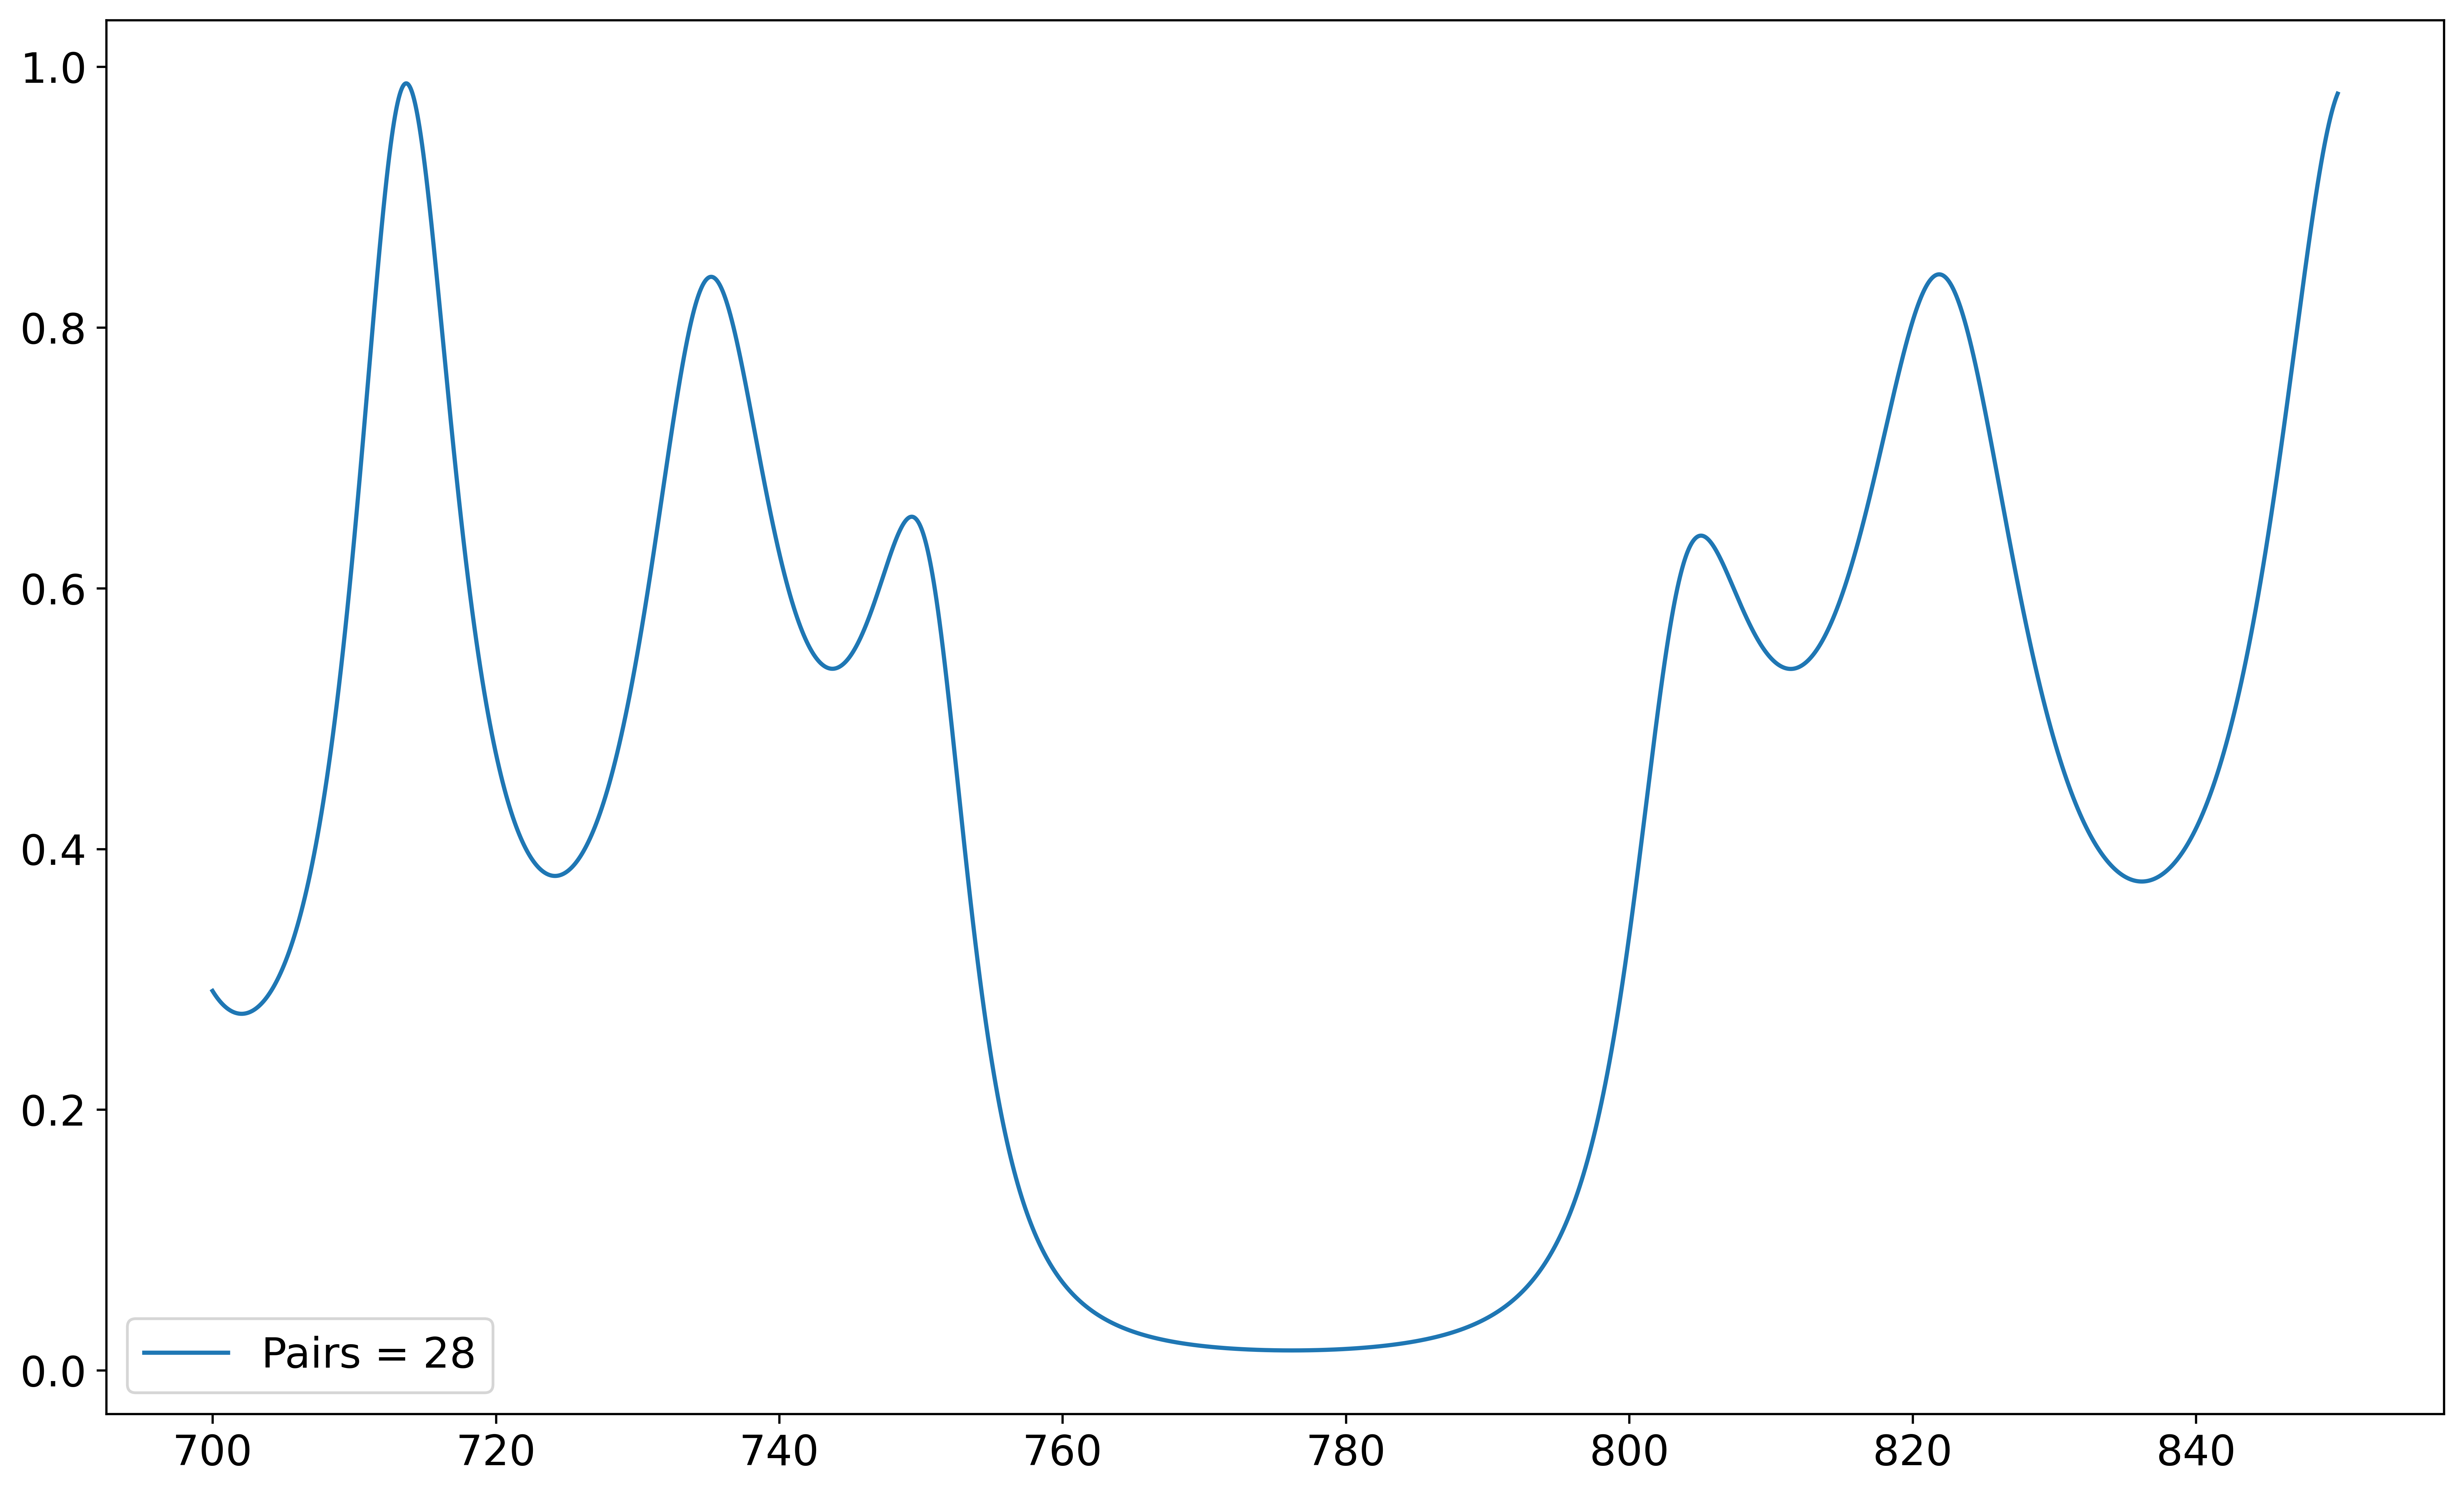

[713.6699999999876]


In [54]:
mirror_pairs = [28]

T = []
R = []
P = []

resonance_location = []

for index, pair in enumerate(mirror_pairs):
    fig, ax = plt.subplots(
        nrows=1,
        ncols=1)

    print(f'Processing pairs: {pair}')

    num_mirror_pairs = pair
    n_high = 3.6
    #t_high = cavity_wavelength / (4 * n_high)
    t_high = 54

    n_low = 3.34
    #t_low = cavity_wavelength / (4 * n_low)
    t_low = 58

    cavity_n = 3.65
    cavity_t = (cavity_wavelength / 2) / cavity_n

    print(f'\t TiO2 thickness: {t_high:.0f} nm')
    print(f'\t AlOx thickness: {t_low:.0f} nm')
    print(f'\t Cavity thickness: {cavity_t:.0f} nm')

    try:
        n.clear()
        t.clear()
    except NameError:
        pass

    n = [n_low, n_high] * num_mirror_pairs
    t = [t_low, t_high] * num_mirror_pairs

    n[7] = cavity_n
    t[7] = cavity_t

    T.clear()
    R.clear()
    P.clear()

    for lam in wavelength:
        k0 = (2 * np.pi) / lam
        M0 = [[1, 0], [0, 1]]

        for k in range(num_mirror_pairs * 2):
            refractive_index = (n[k] ** 2) - (n_effective ** 2)
            nk = np.sqrt(refractive_index) * k0
            nkt = nk * t[k]

            M = [
                [np.cos(nkt), (1j / nk) * np.sin(nkt)],
                [1j * nk * np.sin(nkt), np.cos(nkt)]]
            M0 = np.matmul(M0, M)

        kc = k0 * np.sqrt((n_cladding ** 2) - (n_effective ** 2))
        ks = k0 * np.sqrt((n_substrate ** 2) - (n_effective ** 2))

        transmission = (
            (2 * ks) /
            (
                (ks * M0[0][0]) +
                (kc * M0[1][1]) +
                (ks * kc * M0[0][1]) +
                M0[1][0]))

        reflection = (
            (
                (ks * M0[0][0]) -
                (kc * M0[1][1]) +
                (ks * kc * M0[0][1]) -
                (M0[1][0])) *
            (transmission / (2 * ks)))

        phase = np.arctan(transmission.real / transmission.imag)

        T.append(transmission * transmission.conjugate())
        R.append(reflection * reflection.conjugate())
        P.append(phase)

    y = [1 - r.real for r in R]
    resonance_location.append(wavelength[np.argmax(y)])

    ax.plot(
        wavelength,
        y,
        label=f'Pairs = {pair}')
    ax.legend(loc=0)
    plt.show()

print(resonance_location)